In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

sns.set_style("whitegrid")

In [12]:
df = pd.read_csv('AirQualityUCI.csv', sep=';')
df.drop(columns=['Unnamed: 15','Unnamed: 16'], inplace=True)
df.dropna(inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [13]:
df.info()
# TODO:
# pasar fecha a tipo fecha
# resto a float (?)
# pasar los -200 a nan
print('Data completa, sin elementos NaN')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB
Data completa, sin elementos NaN


Tipo de dato de la columna 'RH' es `object`. Esto es dado que los datos en el archivo .csv separan los valores decimales por coma (,) y no por puntos.

In [14]:
cols = [col  for col in df.columns if df[col].dtype == 'O']
for i in cols:
    if i == 'Time':
        df[i] = df[i].str.replace('.',':')
    else:
        df[i] = df[i].str.replace(',','.')

In [15]:
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_timedelta(df['Time'], errors = 'ignore')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [16]:
print('Perfectooo locoo!!!\n')
df.info()

Perfectooo locoo!!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Date           9357 non-null   datetime64[ns] 
 1   Time           9357 non-null   timedelta64[ns]
 2   CO(GT)         9357 non-null   float64        
 3   PT08.S1(CO)    9357 non-null   float64        
 4   NMHC(GT)       9357 non-null   float64        
 5   C6H6(GT)       9357 non-null   float64        
 6   PT08.S2(NMHC)  9357 non-null   float64        
 7   NOx(GT)        9357 non-null   float64        
 8   PT08.S3(NOx)   9357 non-null   float64        
 9   NO2(GT)        9357 non-null   float64        
 10  PT08.S4(NO2)   9357 non-null   float64        
 11  PT08.S5(O3)    9357 non-null   float64        
 12  T              9357 non-null   float64        
 13  RH             9357 non-null   float64        
 14  AH             9357 non-null   floa

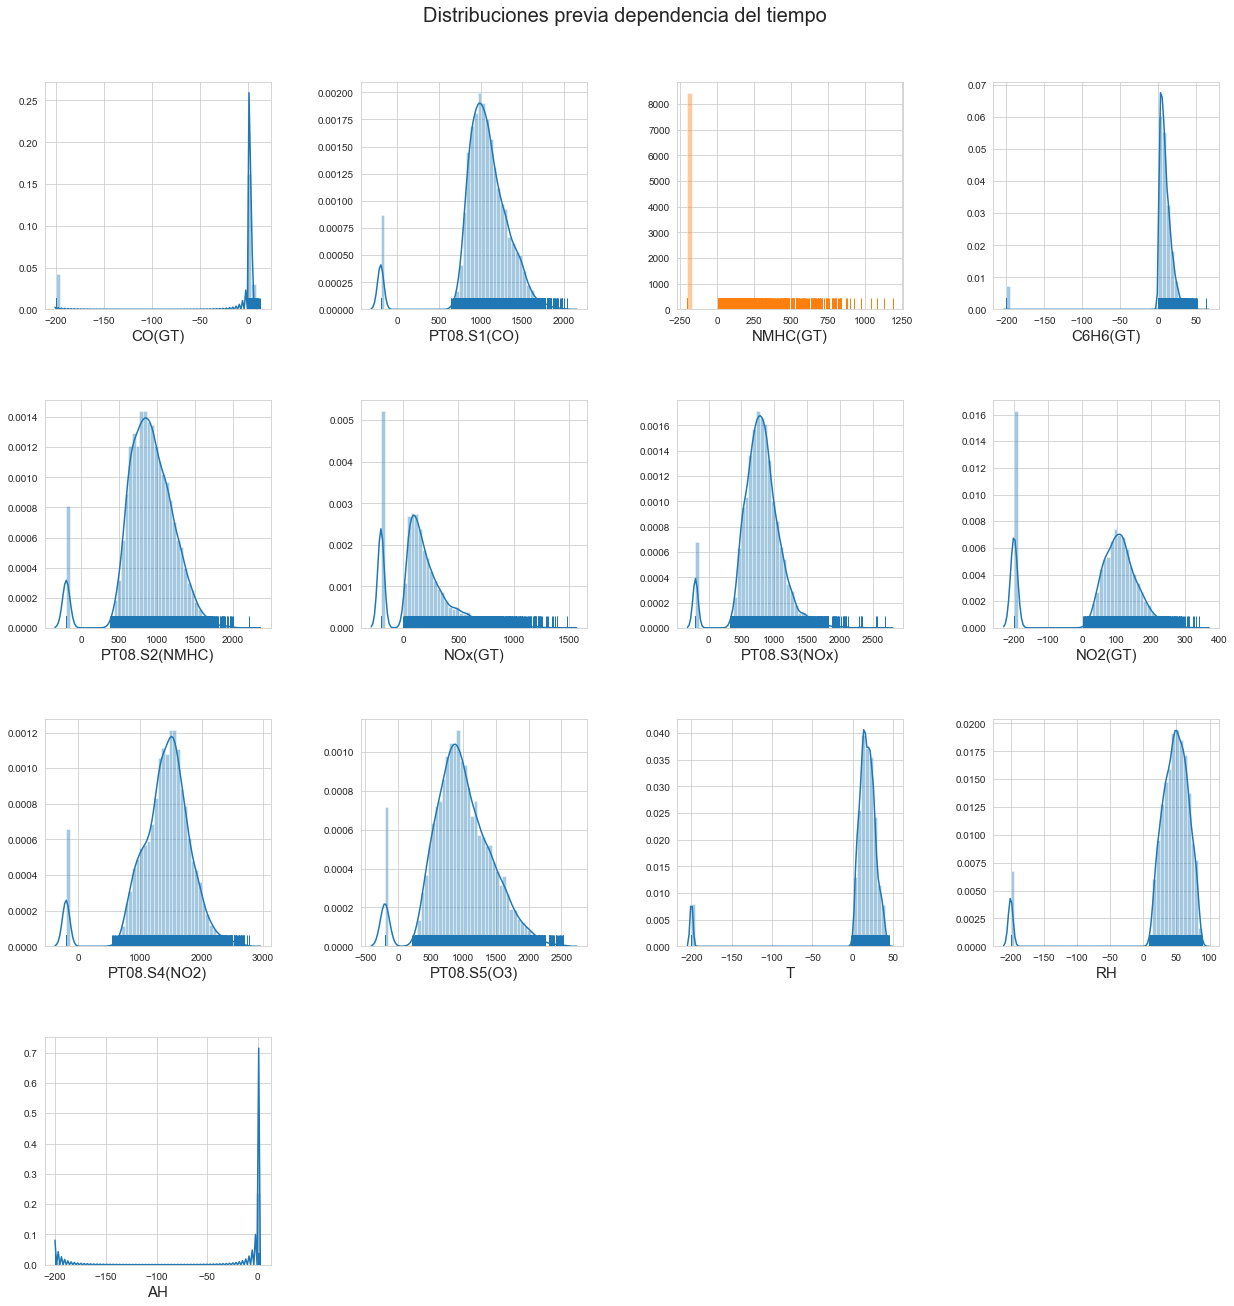

In [17]:
# Vista previa de la distribución de datos sin considerar la dependencia temporal
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
fig.tight_layout()

list(map(lambda a : a.remove(), ax[-1,1:]))
fig.suptitle('Distribuciones previa dependencia del tiempo',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), df.columns[2:]):
    try :
        sns.distplot(df[col], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[col], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

Valores anómalos fueron anotados en el data set con el valor `-200`, totalmente lejano a la naturaleza de los datos (concentración siempre toma valores no negativos). Se considerarán estos valores como `np.nan` y eliminarlos del data set.

In [18]:
#Valores 
ns = np.shape(df)
for i in df.columns:
    for j in range(ns[0]):
        if df[i][j] == -200:
            df[i][j] = np.nan

df = df.dropna(how = 'any')
df.info()

C:\Users\paula\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 827 entries, 0 to 1230
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Date           827 non-null    datetime64[ns] 
 1   Time           827 non-null    timedelta64[ns]
 2   CO(GT)         827 non-null    float64        
 3   PT08.S1(CO)    827 non-null    float64        
 4   NMHC(GT)       827 non-null    float64        
 5   C6H6(GT)       827 non-null    float64        
 6   PT08.S2(NMHC)  827 non-null    float64        
 7   NOx(GT)        827 non-null    float64        
 8   PT08.S3(NOx)   827 non-null    float64        
 9   NO2(GT)        827 non-null    float64        
 10  PT08.S4(NO2)   827 non-null    float64        
 11  PT08.S5(O3)    827 non-null    float64        
 12  T              827 non-null    float64        
 13  RH             827 non-null    float64        
 14  AH             827 non-null    float64        
dtypes: da

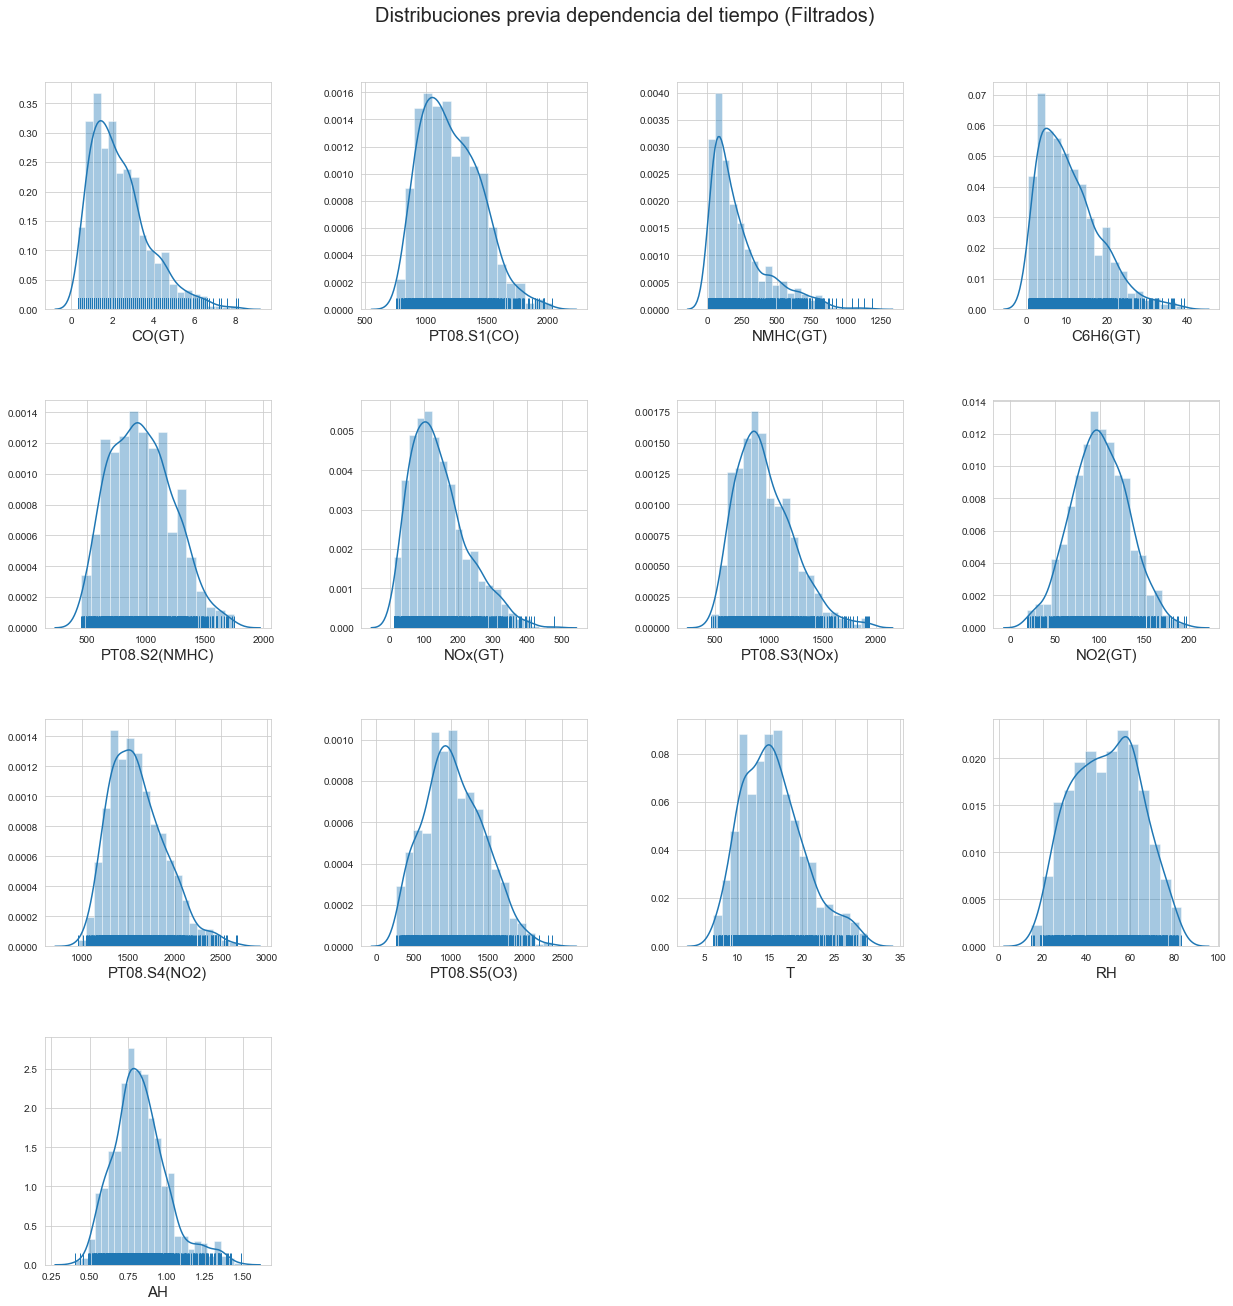

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
fig.tight_layout()

list(map(lambda a : a.remove(), ax[-1,1:]))
fig.suptitle('Distribuciones previa dependencia del tiempo (Filtrados)',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), df.columns[2:]):
    try :
        sns.distplot(df[col], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[col], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.4)